<a href="https://colab.research.google.com/github/salmanromeo/CS_5783_Machine_Learning_Fall_2022/blob/main/1D_Pitching_Moment_PINN_Shafi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1D Pitching Moment Physics-Informed Neural Network (PINN)**

#####This notebook contains the code to reproduce the plots using PINN presented in the paper "Limit Cycle Analysis Applied to the Oscillations of Decelerating Blunt-Body Entry Vehicles". by Mark Schoenenberger and Dr. Eric M. Queen, NASA Langley Research Center, Hampton, VA 23681

**Problem overview**

#####The example problem we solve here is the 1D Pitching Moment Equation for Blunt-Body Entry Vehicles:
\begin{align}
      \ddot{α} - \frac{ρVSd^2} {4I} ({C}_{m_q} + {C}_{m_\dot{α}})\dot{α}-\frac{ρV^2Sd} {2I} {C}_{m_{α}}{α}=0
    \end{align}
#####As all coefficients are constant, this equation is a simple harmonic oscillator with damping, having the classic solution:
\begin{align}
      {α} = Ae^{\epsilon t} cos(ωt+δ)
    \end{align}
#####where
\begin{align}
      \epsilon = \frac{ρVSd^2} {8I} ({C}_{m_q} + {C}_{m_\dot{α}})
    \end{align}
#####and
\begin{align}
      \omega = \sqrt{-\frac{ρV^2Sd} {2I}{C}_{m_{α}}}
    \end{align}

**Parameter setup : Constant Velocity, Free-to-Oscillate, No-Heave**

In [ ]:
from tabulate import tabulate
# Assign Data
mydata = [["Density: rho (kg/m^3)", 1.20],["Velocity: v (m/s)", 858],["Reference area: s (m^2)", 0.00385],["Reference diameter: d (m)", 0.07],
          ["Moment-of-inertia: I (kg.m^2)", 1.55e-4],["Phase shift constant: dlt", 0],["Angle-of-attack constant: A", 1],
          ["Pitching moment slope: C_m_alpha (rad^-1)", -0.09],["Pitch damping coefficient: C_m_q + C_m_alpha", 0]]
# Create Header
head = ["Model Properties", "Test Parameters"]
# Display Table
print(tabulate(mydata, headers=head, tablefmt="grid", numalign="center"))

+----------------------------------------------+-------------------+
| Model Properties                             |  Test Parameters  |
+==============================================+===================+
| Density: rho (kg/m^3)                        |        1.2        |
+----------------------------------------------+-------------------+
| Velocity: v (m/s)                            |        858        |
+----------------------------------------------+-------------------+
| Reference area: s (m^2)                      |      0.00385      |
+----------------------------------------------+-------------------+
| Reference diameter: d (m)                    |       0.07        |
+----------------------------------------------+-------------------+
| Moment-of-inertia: I (kg.m^2)                |     0.000155      |
+----------------------------------------------+-------------------+
| Phase shift constant: dlt                    |         0         |
+---------------------------------

**Environment**

In [37]:
# Libraries
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

**Helper function for saving GIFs**

In [38]:
def save_gif_PIL(outfile, files, fps=5, loop=0):
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)

**The analytical solution to the 1D Pitching Moment Equation**

In [39]:
# Defines the analytical solution

def oscillator(A, ro, v, s, d, CM_q_a, CM_a, I, phi, t):
    w = np.sqrt(-((ro*v**2*s*d*CM_a)/(2*I)))    # w is omega
    cos = torch.cos(w*t + phi)
    e = (ro*v*s*d**2)*(CM_q_a)/(8*I)            # e is epsilon
    exp = torch.exp(e*t)
    y  = A*exp*cos                              # y is alpha
    return y

**Define a connected network**

In [40]:
# Defines a standard fully-connected network in PyTorch

class FCN(nn.Module):

    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

**Assign parameters**

In [41]:
# Main
A       = 1
ro      = 1.20
v       = 858
s       = 0.00385
d       = 0.07
CM_q_a  = 0.15            # CM_q_a  = np.array([0.15, 0, -0.171, -0.342])
CM_a    = -0.09
I       = 1.55e-4
phi     = 0

**Get the analytical solution over the full domain**

In [42]:
# get the analytical solution over the full domain
t = torch.linspace(0,0.1,100).view(-1,1)                           # time from 0 to 0.1
y = oscillator(A, ro, v, s, d, CM_q_a, CM_a, I, phi, t).view(-1,1)
print(t.shape, y.shape)

torch.Size([100, 1]) torch.Size([100, 1])


**Generate training data**

#####First, we generate some training data from a small part of the true analytical solution.

torch.Size([50, 1]) torch.Size([50, 1])


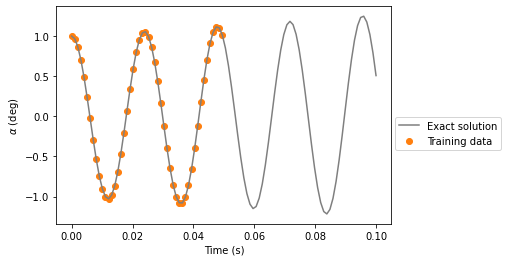

In [9]:
# slice out a small number of points from the LHS of the domain
t_data = t[0:50:1]   # time data 
y_data = y[0:50:1]   # alpha data
print(t_data.shape, y_data.shape)

plt.figure()
plt.plot(t, y, label="Exact solution", color="tab:grey")
plt.scatter(t_data, y_data, color="tab:orange", label="Training data")
plt.xlabel("Time (s)")
plt.ylabel(r'$\alpha$ (deg)')
plt.legend(loc=(1.01,0.34))
plt.show()

**Plot training results**

In [10]:
def plot_result(t,y,t_data,y_data,yh,xp=None):

    plt.figure()
    plt.plot(t,y, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.plot(t,yh, color="tab:green", linewidth=4, alpha=0.8, label="Neural network prediction")
    plt.scatter(t_data, y_data, s=60, color="tab:orange", alpha=0.4, label='Training data')
    if xp is not None:
        plt.scatter(xp, -0*torch.ones_like(xp), s=60, color="tab:green", alpha=0.4, 
                    label='Physics loss training locations')
    l = plt.legend(loc=(1.01,0.34), frameon=False, fontsize="xx-large")
    plt.setp(l.get_texts(), color="k")
    plt.title(f"Training step {i}")
    plt.axis("on")

**Normal neural network**

#####Next, we train a standard neural network (fully connected network) to fit these training points.
#####We find that the network is able to fit the solution very closely in the vicinity of the training points, but does not learn an accurate solution outside of them.

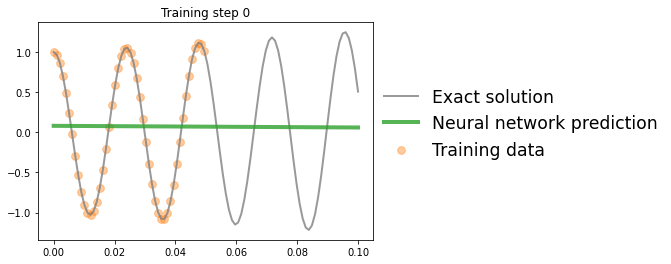

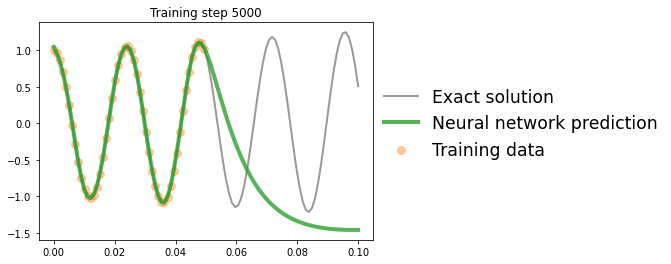

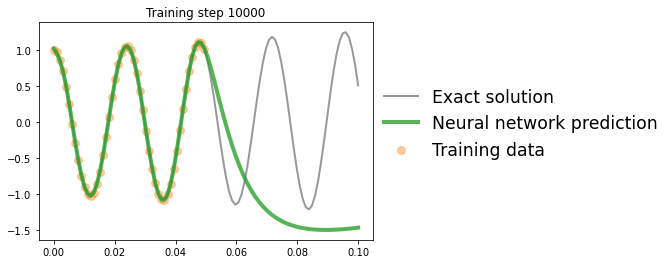

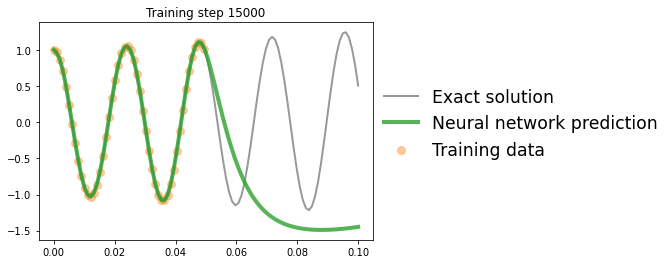

In [20]:
# train standard neural network to fit training data
torch.manual_seed(123)
model = FCN(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)   # learning rate = 1e-2
files = []
for i in range(20000):                                      # epochs = 4000
    optimizer.zero_grad()
    yh = model(t_data)
    loss = torch.mean((yh-y_data)**2)                      # use mean squared error
    loss.backward()
    optimizer.step()
  
    # plot the result as training progresses
    if (i) % 5000 == 0: 
        
        yh = model(t).detach()
        
        plot_result(t,y,t_data,y_data,yh)
        
        file = "/content/sample_data/plots/nn_%.8i.png"%(i+1)     # create plot folder and define the directory
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
    
        if (i) % 5000 == 0: plt.show()
        else: plt.close("all")
            
save_gif_PIL("nn.gif", files, fps=5, loop=0)

**Task 1: Train a PINN to simulate the system**

#####Finally, we add the underlying differential equation ("physics loss") to the loss function.
\begin{align}
      \ddot{α} - \frac{ρVSd^2} {4I} ({C}_{m_q} + {C}_{m_\dot{α}})\dot{α}-\frac{ρV^2Sd} {2I} {C}_{m_{α}}{α}=0
    \end{align}
#####The physics loss aims to ensure that the learned solution is consistent with the underlying differential equation. This is done by penalising the residual of the differential equation over a set of locations sampled from the domain.
#####Here we evaluate the physics loss at 30 points uniformly spaced over the problem domain. We can calculate the derivatives of the network solution with respect to its input variable at these points using pytorch's autodifferentiation features, and can then easily compute the residual of the differential equation using these quantities.

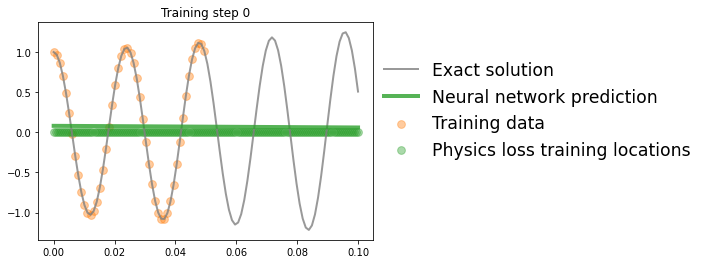

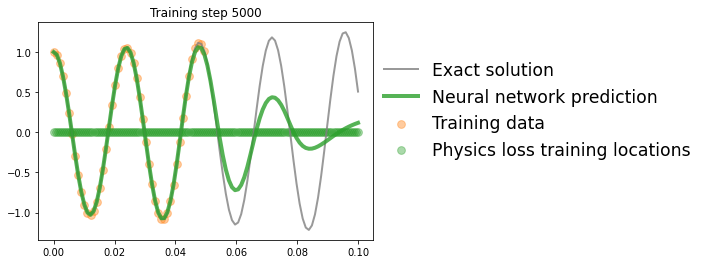

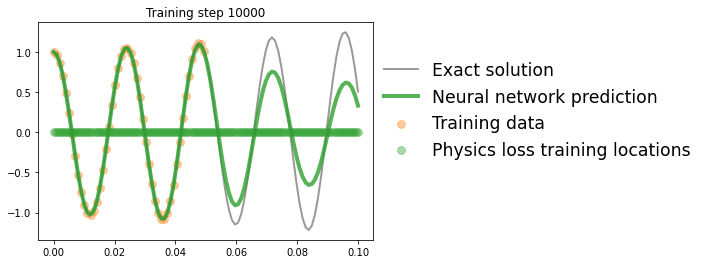

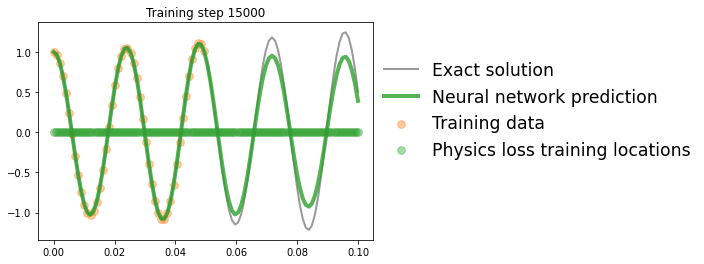

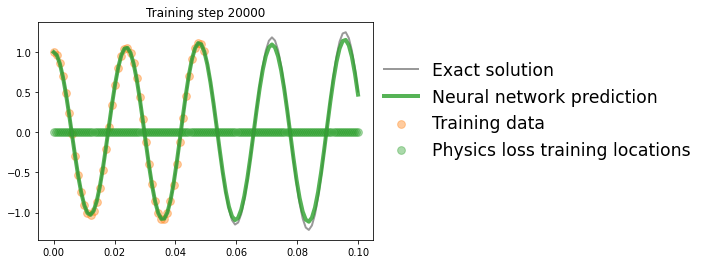

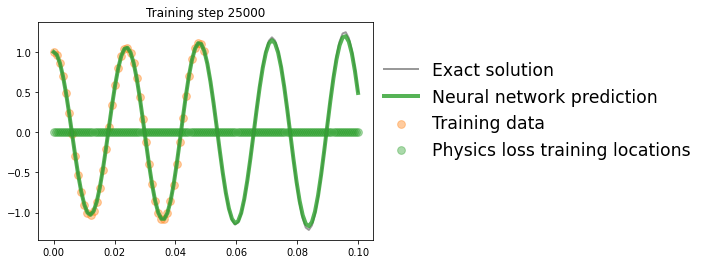

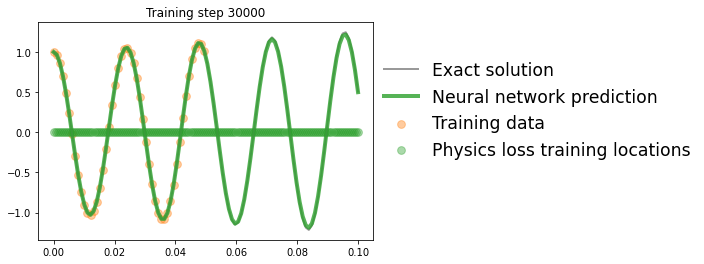

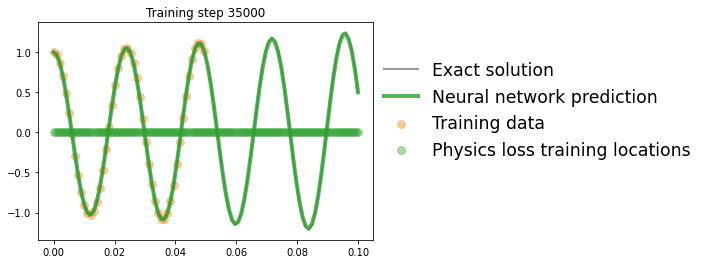

In [22]:
t_physics = torch.linspace(0,0.1,150).view(-1,1).requires_grad_(True)# sample locations over the problem domain
mu = -((ro*v*s*d**2)*(CM_q_a)/(4*I))   # mu is the coefficient ahead alpha_dot
k = -((ro*v**2*s*d*CM_a)/(2*I))        # k is the coefficient ahead alpha

torch.manual_seed(123)
model = FCN(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)   # learning rate = 1e-2
files = []
for i in range(40000):                                     # epochs = 20000
    optimizer.zero_grad()
    
    # compute the "data loss"
    yh = model(t_data)
    loss1 = torch.mean((yh-y_data)**2)                     # use mean squared error
    
    # compute the "physics loss"
    yhp = model(t_physics)
    dt  = torch.autograd.grad(yhp, t_physics, torch.ones_like(yhp), create_graph=True)[0]     # computes dy/dx
    dt2 = torch.autograd.grad(dt,  t_physics, torch.ones_like(dt),  create_graph=True)[0]     # computes d^2y/dx^2
    physics = dt2 + mu*dt + k*yhp                                                             # computes the residual of the 1D harmonic oscillator differential equation
    loss2 = (1e-10)*torch.mean(physics**2)
    
    # backpropagate joint loss
    loss = loss1 + loss2                                   # add two loss terms together
    loss.backward()
    optimizer.step()
    
    # plot the result as training progresses
    if (i) % 5000 == 0: 
        
        yh = model(t).detach()
        xp = t_physics.detach()
        
        plot_result(t,y,t_data,y_data,yh,xp)
        
        file = "/content/sample_data/plots/pinn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
        
        if (i) % 5000 == 0: plt.show()
        else: plt.close("all")
            
save_gif_PIL("pinn.gif", files, fps=5, loop=0)

#####We find that the pinn is able to fit the solution very closely in the vicinity of the training points and learn an accurate solution outside of them within 20000 epoches.

**Task 2: Train a PINN to simulate the system for high frequency**

In [43]:
# get the analytical solution over the full domain
t = torch.linspace(0,0.3,300).view(-1,1)                           # time from 0 to 0.1
y = oscillator(A, ro, v, s, d, CM_q_a, CM_a, I, phi, t).view(-1,1)
print(t.shape, y.shape)

torch.Size([300, 1]) torch.Size([300, 1])


torch.Size([150, 1]) torch.Size([150, 1])


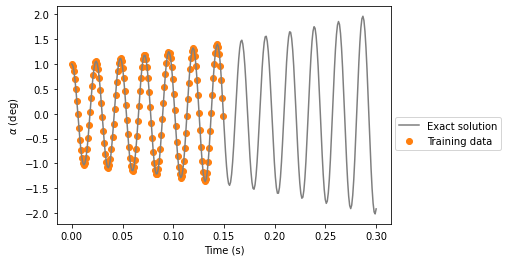

In [44]:
# slice out a small number of points from the LHS of the domain
t_data = t[0:150:1]   # time data 
y_data = y[0:150:1]   # alpha data
print(t_data.shape, y_data.shape)

plt.figure()
plt.plot(t, y, label="Exact solution", color="tab:grey")
plt.scatter(t_data, y_data, color="tab:orange", label="Training data")
plt.xlabel("Time (s)")
plt.ylabel(r'$\alpha$ (deg)')
plt.legend(loc=(1.01,0.34))
plt.show()

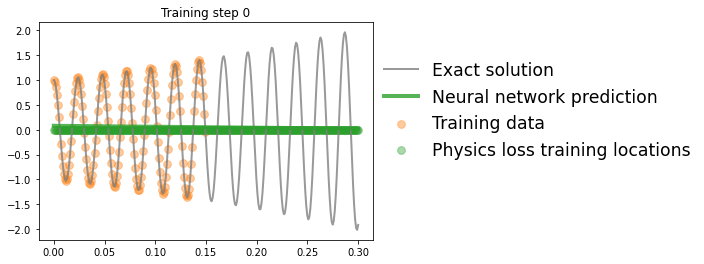

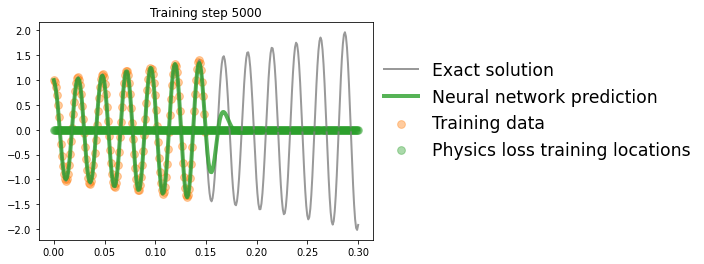

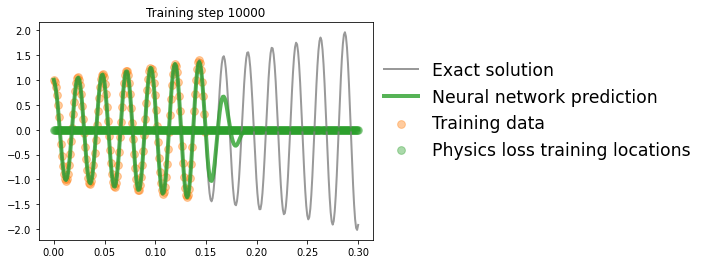

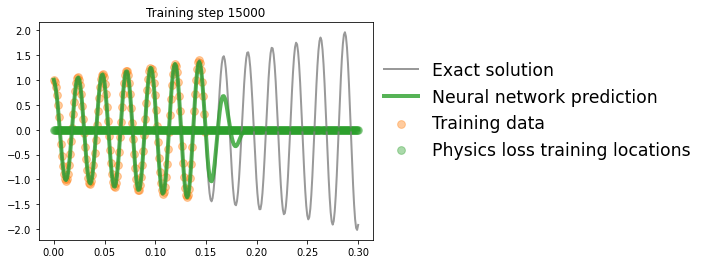

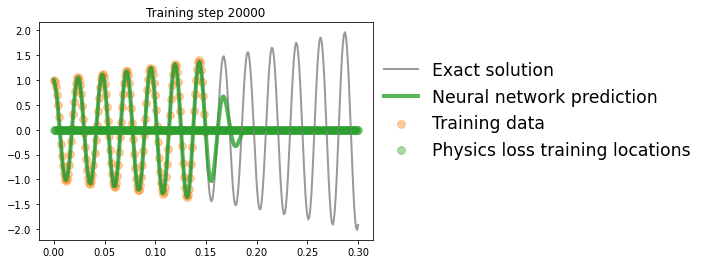

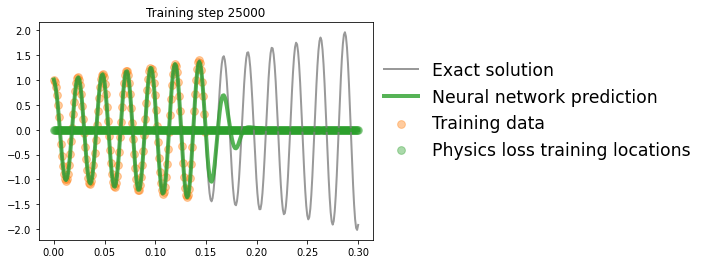

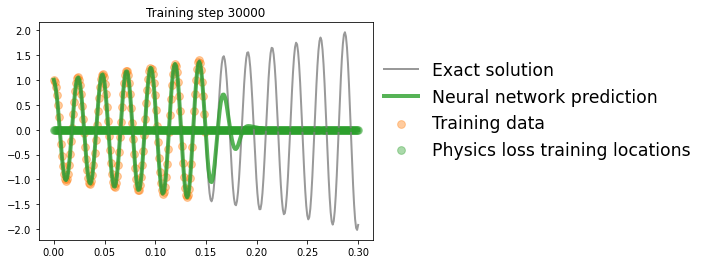

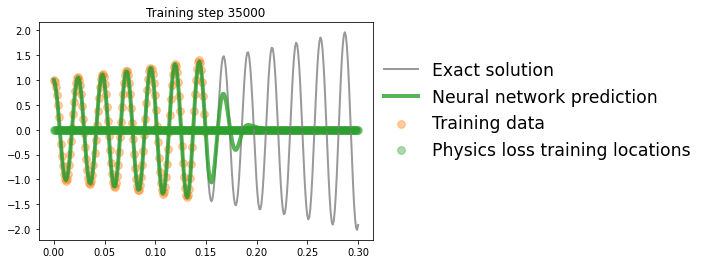

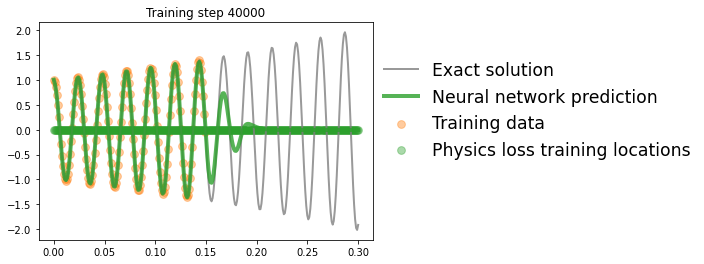

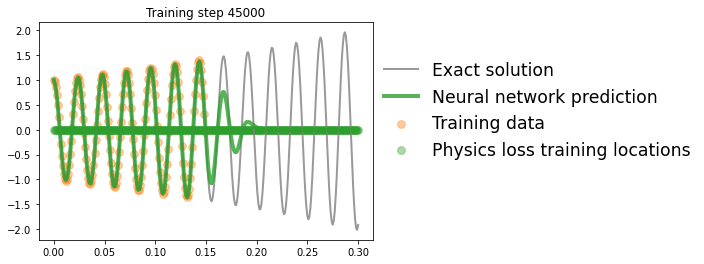

In [29]:
t_physics = torch.linspace(0,0.3,300).view(-1,1).requires_grad_(True)# sample locations over the problem domain
mu = -((ro*v*s*d**2)*(CM_q_a)/(4*I))   # mu is the coefficient ahead alpha_dot
k = -((ro*v**2*s*d*CM_a)/(2*I))        # k is the coefficient ahead alpha

torch.manual_seed(123)
model = FCN(1,1,32,3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)   # learning rate = 1e-2
files = []
for i in range(50000):                                     # epochs = 20000
    optimizer.zero_grad()
    
    # compute the "data loss"
    yh = model(t_data)
    loss1 = torch.mean((yh-y_data)**2)                     # use mean squared error
    
    # compute the "physics loss"
    yhp = model(t_physics)
    dt  = torch.autograd.grad(yhp, t_physics, torch.ones_like(yhp), create_graph=True)[0]     # computes dy/dx
    dt2 = torch.autograd.grad(dt,  t_physics, torch.ones_like(dt),  create_graph=True)[0]     # computes d^2y/dx^2
    physics = dt2 + mu*dt + k*yhp                                                             # computes the residual of the 1D harmonic oscillator differential equation
    loss2 = (1e-10)*torch.mean(physics**2)
    
    # backpropagate joint loss
    loss = loss1 + loss2                                   # add two loss terms together
    loss.backward()
    optimizer.step()
    
    # plot the result as training progresses
    if (i) % 5000 == 0: 
        
        yh = model(t).detach()
        xp = t_physics.detach()
        
        plot_result(t,y,t_data,y_data,yh,xp)
        
        file = "/content/sample_data/plots/h_pinn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
        
        if (i) % 5000 == 0: plt.show()
        else: plt.close("all")
            
save_gif_PIL("h_pinn.gif", files, fps=5, loop=0)

#####We can see that the PINN struggles to converge, even if the number of physics training points is increased. This is a harder problem for the PINN to solve, in part because of the spectral bias of neural networks, as well as the fact more training points are required.

**Train a PINN to simulate the system for high frequency "ansatz" formulation**

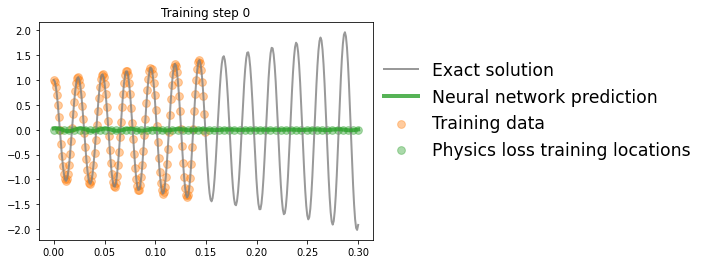

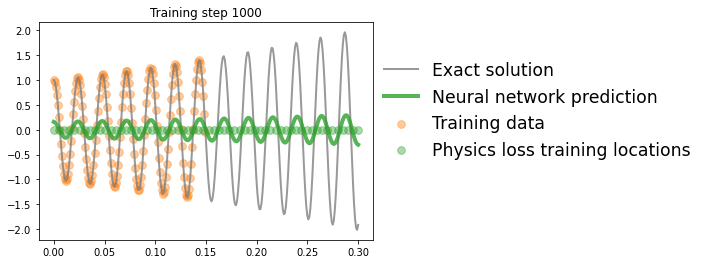

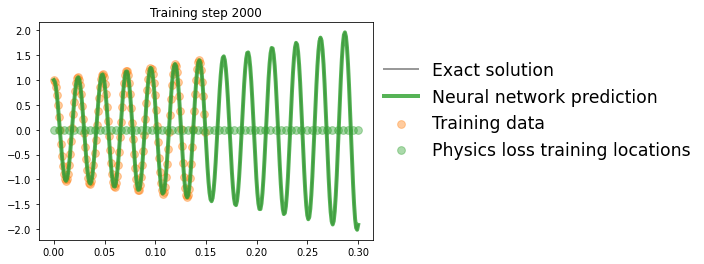

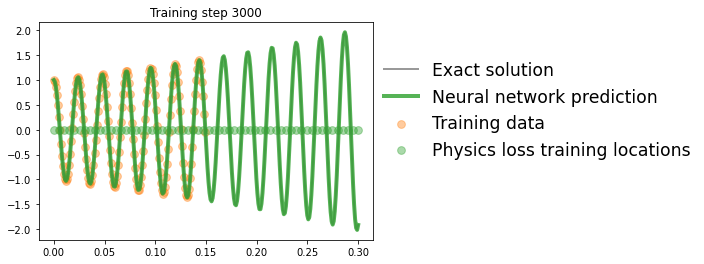

In [52]:
t_physics = torch.linspace(0,0.3,60).view(-1,1).requires_grad_(True) # sample locations over the problem domain
#t_boundary = torch.tensor(0.).view(-1,1).requires_grad_(True) # define boundary points, for the boundary loss
mu = -((ro*v*s*d**2)*(CM_q_a)/(4*I))   # mu is the coefficient ahead alpha_dot
k = -((ro*v**2*s*d*CM_a)/(2*I))        # k is the coefficient ahead alpha

torch.manual_seed(123)
model = FCN(1,1,32,3)

# define additional a,b learnable parameters in the ansatz
# TODO: write code here
a = torch.nn.Parameter(260*torch.ones(1, requires_grad=True))
b = torch.nn.Parameter(torch.ones(1, requires_grad=True))

optimizer = torch.optim.Adam(list(model.parameters())+[a,b],lr=1e-3)   # learning rate = 1e-2
files = []
for i in range(4000):                                     # epochs = 20000
    optimizer.zero_grad()
    
    # compute boundary loss
    # TODO: write code here (change to ansatz formulation)
    #u = model(t_boundary)*torch.sin(a*t_boundary+b)
    #loss1 = (torch.squeeze(u) - 1)**2
    #dudt = torch.autograd.grad(u, t_boundary, torch.ones_like(u), create_graph=True)[0]
    #loss2 = (1e-1)*(torch.squeeze(dudt) - 0)**2

    # compute the "data loss"
    #yh = model(t_data)*torch.sin(a*t_data+b)
    yh = model(t_data)*torch.sin(a*t_data+b)
    loss1 = torch.mean((yh-y_data)**2)                     # use mean squared error
    
    # compute the "physics loss"
    yhp = model(t_physics)*torch.sin(a*t_physics+b)
    dt  = torch.autograd.grad(yhp, t_physics, torch.ones_like(yhp), create_graph=True)[0]     # computes dy/dx
    dt2 = torch.autograd.grad(dt,  t_physics, torch.ones_like(dt),  create_graph=True)[0]     # computes d^2y/dx^2
    physics = dt2 + mu*dt + k*yhp                                                             # computes the residual of the 1D harmonic oscillator differential equation
    loss2 = (0.6e-5)*torch.mean(physics**2)
    
    # backpropagate joint loss
    loss = loss1 + loss2                                   # add two loss terms together
    loss.backward()
    optimizer.step()
    
    # plot the result as training progresses
    if (i) % 1000 == 0: 
        
        yh = (model(t)*torch.sin(a*t+b)).detach()
        xp = t_physics.detach()
        
        plot_result(t,y,t_data,y_data,yh,xp)
        
        file = "/content/sample_data/plots/S_h_pinn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)
        
        if (i) % 1000 == 0: plt.show()
        else: plt.close("all")
            
save_gif_PIL("S_h_pinn.gif", files, fps=5, loop=0)